## Text to Image Model

The code below uses a conditional diffusion model to generate images based on a text prompt.

This diffusion model was trained from scratch and is light (100MM params) and trained on only 1 million images.

Note that this notebook does **not** read or write anything to your machine nor does it need any access to google drive or outside sources. All the downloads happen within this notebook and once you close it, it will all go gone poof!

- Author: Alexandru Papiu
- Email: alexpapiu@gmail.com
- To see more details on the code and model training go to the following [Github Repo](https://github.com/apapiu/transformer_latent_diffusion/edit/main/README.md)

Example Generations:

<img width="800" alt="image" src="https://github.com/apapiu/transformer_latent_diffusion/assets/13619417/4bbb9a17-5dd5-416f-8271-3c8d157fc4bd">

### Run this to install - Should take about 1 minute.


In [1]:
%%capture
!pip install git+https://github.com/apapiu/transformer_latent_diffusion.git@main_legacy
!wget https://huggingface.co/apapiu/small_ldt/resolve/main/state_dict_378000.pth

import sys
sys.path.append('transformer_latent_diffusion')
from tld.denoiser import Denoiser
from tld.diffusion import DiffusionGenerator

from diffusers import AutoencoderKL, AutoencoderTiny
from tqdm import tqdm
import clip
import torch
import numpy as np
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

to_pil = transforms.ToPILImage()

@torch.no_grad()
def encode_text(label, model):
    text_tokens = clip.tokenize(label, truncate=True).cuda()
    text_encoding = model.encode_text(text_tokens)
    return text_encoding.cpu()


denoiser = Denoiser(image_size=32, noise_embed_dims=256, patch_size=2,
                 embed_dim=768, dropout=0, n_layers=12)


state_dict = torch.load('state_dict_378000.pth')

denoiser = denoiser.half()
denoiser.load_state_dict(state_dict)
denoiser = denoiser.to(device)

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", #'madebyollin/taesdxl',
                                    torch_dtype=torch.float16).to(device)

clip_model, preprocess = clip.load("ViT-L/14")
clip_model = clip_model.to(device)

diffuser = DiffusionGenerator(denoiser, vae, device, torch.float16)

###config:
vae_scale_factor = 8
img_size = 32

## Image Generator:

100%|██████████| 19/19 [00:01<00:00, 14.48it/s]


Images Generated and Saved. They will shortly output below.


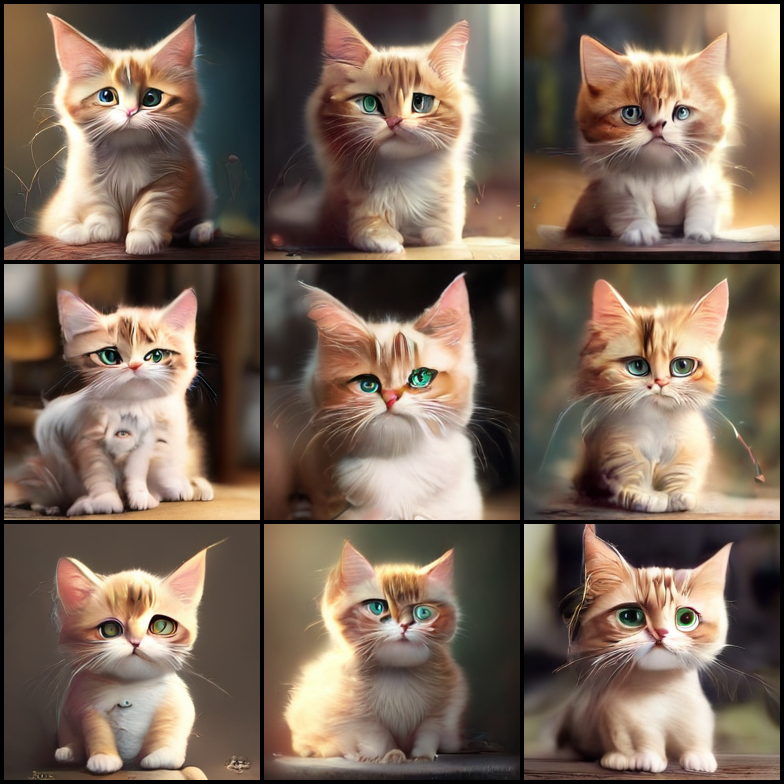

In [5]:
prompt = "a cute cat" #@param {type:"string"}
class_guidance = 6 #@param {type:"slider", min:0, max:15, step:0.5}
n_iter = 20
###@param {type:"slider", min:0, max:60, step:1}
num_imgs = 9 #@param {type:"slider", min:1, max:36, step:1}
img_size = 32
seed = 11 #@param{}
nrow = int(np.sqrt(num_imgs))


cur_prompts = [prompt]*num_imgs
labels = encode_text(cur_prompts, clip_model)
out, out_latent = diffuser.generate(labels=labels,
                                    num_imgs=num_imgs,
                                    class_guidance=class_guidance,
                                    seed=seed,
                                    n_iter=n_iter,
                                    exponent=1,
                                    scale_factor=8,
                                    sharp_f=0,
                                    bright_f=0
                                        )

out = to_pil((vutils.make_grid((out+1)/2, nrow=nrow, padding=4)).float().clip(0, 1))

out.save(f'{prompt}_cfg:{class_guidance}_seed:{seed}.png')

print("Images Generated and Saved. They will shortly output below.")

out


## Clip Interpolation:
The model will generate images conditioned on a linear interpolation between the text embedding for prompt 1 and the text embedding for prompt 2 using the same seed.

100%|██████████| 29/29 [00:02<00:00, 14.46it/s]


Images Generated. They will shortly output below.


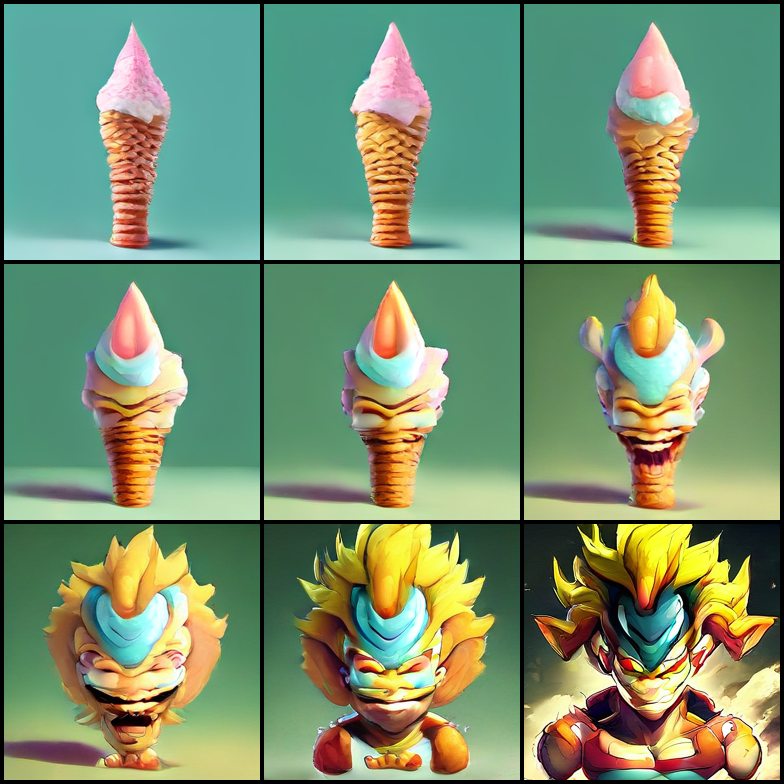

In [6]:


prompt1 = "an ice cream cone" #@param {type:"string"}
prompt2 = "dragon ball-z" #@param {type:"string"}
class_guidance = 7 #@param {type:"slider", min:0, max:15, step:0.5}
n_iter = 30 #@param {type:"slider", min:0, max:100, step:1}
num_imgs = 9 #@param {type:"slider", min:1, max:36, step:1}
img_size = 32
seed = 9 #@param{}
nrow = int(np.sqrt(num_imgs))


gen = torch.Generator()
gen.manual_seed(seed)
seeds = torch.randn(1,4,32,32, generator=gen).repeat(num_imgs,1,1,1)
wws = [0, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 1]

cur_prompts = [prompt]*num_imgs

enc2 = encode_text([prompt1], clip_model)
enc1 = encode_text([prompt2], clip_model)

labels = encode_text(cur_prompts, clip_model)
labels = torch.cat([enc1*w+enc2*(1-w) for w in wws], 0)
out, out_latent = diffuser.generate(labels=labels,
                                    seeds=seeds,
                                    num_imgs=num_imgs,
                                    class_guidance=class_guidance,
                                    seed=seed,
                                    n_iter=n_iter,
                                    exponent=1,
                                    sharp_f=0.15,
                                        )

out = to_pil((vutils.make_grid((out+1)/2, nrow=nrow, padding=4)).float().clip(0, 1))

out.save(f'{prompt}_cfg:{class_guidance}_seed:{seed}.png')

print("Images Generated. They will shortly output below.")

out
